# Pre-training DelphBERT - A tiny Transformer model based on a large newspaper dataset

In [2]:
import glob
import os
import re
# Set cache to external hd
os.environ['TRANSFORMERS_CACHE'] = '/home/leonardovida/data/volume_1/huggingface_cache/'
os.environ['HF_DATASETS_CACHE'] = '/home/leonardovida/data/volume_1/huggingface_cache/'
from pathlib import Path

from typing import Any, Dict, List, NamedTuple, Optional, Sequence, Tuple, Union

from tokenizers import Tokenizer
from tokenizers import ByteLevelBPETokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from transformers import RobertaConfig
from transformers import RobertaTokenizerFast
from transformers import BertTokenizer
from transformers import PreTrainedTokenizer
from transformers import TrainingArguments
from transformers import RobertaForMaskedLM
from datasets import Dataset, DatasetDict
from datasets import load_from_disk

from tqdm.notebook import tqdm
from nltk.tokenize import sent_tokenize
tqdm.pandas()

import torch
from torch import Tensor
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm

First, we need to load the entire "processed" library of Delpher newspaper on the transformer.

* Even though we are loading clean and unclean text, we are training using the **unclean** text.
* Transformers "want" complete sentences and the clean text does not have stopwords nor lower-upper cases. Thus, we will first take the "merged" dataset and use it in two different approaches.

1. We will clean the merged dataset, dividing each paragraph in its own row, and save it as TXT file. 
    * This text file will be used to train a tokenizer on it
    * This text file will also be used to train a transfromer on it using the NVIDIA approach
2. We will transform the merged dataset into a HuggingFace dataset, this dataset will be used to share the data with other people and
to train transformers with the HuggingFace script

## Load Data

In [4]:
PATH_RAW_FILES = "/home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s"
PATH_TOKENIZER_DIR = "/home/leonardovida/data/volume_1/data-histaware/tokenizer"
PATH_DATASET_DIR = "/home/leonardovida/data/volume_1/data-histaware/dataset"

# For tokenizer
PRE_TRAINED_MODEL_NAME = 'wietsedv/bert-base-dutch-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#!mkdir PATH_MODEL_DIR

## From CSV to Text

In [84]:
csv_paths = [str(x) for x in Path(PATH_RAW_FILES).glob("*.csv")]

def clean(article):
    words = re.sub(r"[-\[\]\#/@;:<>{}=~|*»]", "", str(article)) # cleaning useless parts of sentences
    words = re.sub(r"^\s*|\s\s*", " ", words).strip() # reduce spaces
    words = re.sub(r'[^\x00-\x7F]+', "", words) # eliminate non unicode chars
    return words

def tokenize_sent(article):
    sents = sent_tokenize(article)
    return sents

for csv in csv_paths:
    df = pd.read_csv(csv, converters={'p': eval})
    df.drop(columns = ['Unnamed: 0', 'article_name', 'date', 'index_article',
                                  'article_filepath', 'dir', 'title', 'access_rights',
                                  'identifier', 'metadata_title', 'index_metadata', 'metadata_filepath',
                                  'newspaper_title', 'newspaper_date', 'newspaper_publisher', 'newspaper_source',
                                  'newspaper_volume', 'newspaper_issuenumber', 'newspaper_recordIdentifier',
                                  'transformedRecordIdentifier', 'recordIdentifier'], inplace=True)
    df = df[df["subject"] == "artikel"]
    print(f"CSV: {csv}")
    print(df.shape[0])
    df = df.explode('p', ignore_index = True)
    print(df.shape[0])
    df["p"] = df.progress_apply(lambda x: clean(x["p"]), axis=1)
    # We are not tokenizing sentences, as the tokenized sentences are not clean enough
    #df["p"] = df.progress_apply(lambda x: tokenize_sent(x["p"]), axis=1)
    #df = df.explode('p', ignore_index = True)
    df["p"].to_csv(r'/home/leonardovida/data/volume_1/data-histaware/dataset/data.1970.txt', header=None, index=None, sep='\n', mode='a')
    print("Saved")

CSV: /home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s/merged_1970s_100.csv
596439
1472965



CSV: /home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s/merged_1970s_60.csv
598306
1455737



CSV: /home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s/merged_1970s_20.csv
633428
1538910



CSV: /home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s/merged_1970s_140.csv
598242
1466379



CSV: /home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s/merged_1970s_80.csv
601051
1459106



CSV: /home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s/merged_1970s_40.csv
567544
1396036



CSV: /home/leonardovida/data/volume_1/data-histaware/merged_articles/1970s/merged_1970s_120.csv
591197
1467397


Test loading the text file

# Load data into Dataset directly from .csv

In [5]:
import datasets

csv_paths = [str(x) for x in Path(PATH_RAW_FILES).glob("*.csv")]
dataset = datasets.load_dataset(
    "csv",
    data_files = csv_paths,
    cache_dir = '/home/leonardovida/data/volume_1/huggingface_cache/'
)

Using custom data configuration default-6f257d010843fb18
Reusing dataset csv (/home/leonardovida/data/volume_1/huggingface_cache/csv/default-6f257d010843fb18/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Remove columns that are not necessary in the training

In [ ]:
dataset = dataset.remove_columns(['Unnamed: 0', 'article_name', 'date', 'index_article',
                                  'article_filepath', 'dir', 'title', 'access_rights',
                                  'identifier', 'metadata_title', 'index_metadata', 'metadata_filepath',
                                  'newspaper_title', 'newspaper_date', 'newspaper_publisher', 'newspaper_source',
                                  'newspaper_volume', 'newspaper_issuenumber', 'newspaper_recordIdentifier',
                                  'transformedRecordIdentifier'])

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'article_name', 'date', 'index_article', 'article_filepath', 'dir', 'title', 'p', 'subject', 'access_rights', 'recordIdentifier', 'identifier', 'metadata_title', 'index_metadata', 'metadata_filepath', 'newspaper_title', 'newspaper_date', 'newspaper_publisher', 'newspaper_source', 'newspaper_volume', 'newspaper_issuenumber', 'newspaper_recordIdentifier', 'transformedRecordIdentifier'],
        num_rows: 7007009
    })
})

In [26]:
dataset = dataset.filter(lambda article: article['subject'] == "artikel")

## High-level Data Cleaninig

Always visually check to understand if dataset is actually what you expect

In [99]:
import re

def paragraph_clean(article):
    """Basic cleaning of paragraphs.
    
    More can and will be done in the tokenizing step.
    """
    words = re.sub(r"[-\[\]\"'#/@;,:<>{}=~|*»]", "", article["p"]) # cleaning useless parts of sentences
    words = re.sub(r"^\s*|\s\s*", " ", words).strip() # reduce spaces
    words = re.sub(r'[^\x00-\x7F]+', "", words) # eliminate non unicode chars
    return {"p_clean": words}

In [100]:
dataset = dataset.map(paragraph_clean, num_proc=9)

In [114]:
dataset.save_to_disk(PATH_DATASET_DIR)

### Divide each paragraph into sentences

In [21]:
import re
from nltk.tokenize import sent_tokenize

def sentence_tokenize(article):
    """Tokenize sentences from paragraphs."""
    sents = sent_tokenize(article["p_clean"])
    #sents = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)(\s|[A-Z].*)', article["p_clean"])
    return {"sentences": sents}

dataset = dataset.map(sentence_tokenize, num_proc=9)

Check for sentences

### Check distribution of paragraph lengths

Use pre-trained tokenizer to tokenize individual sentences. We do this to check for the length of each individual sentence and understand how much data we will lose when truncating on pre-training (the maximum length of BERT is 512 tokens). 

We also want to understand the overall distribution of the sentences and check how many short sentences there are in the dataset. We will put a bottom and top limit for each article

In [28]:
from transformers import BertTokenizer

def build_dist(article):
    sents_len = []
    for sent in article["sentences"]:
        sents_len.append(len(sent.split()))
    return {"sents_len": sents_len}

In [29]:
dataset = dataset.map(build_dist, num_proc=8)

### Check dist of first 100000

In [36]:
sents = dataset["train"]["sents_len"][1:1000000]

In [37]:
flat_list = [item for sublist in sents for item in sublist]

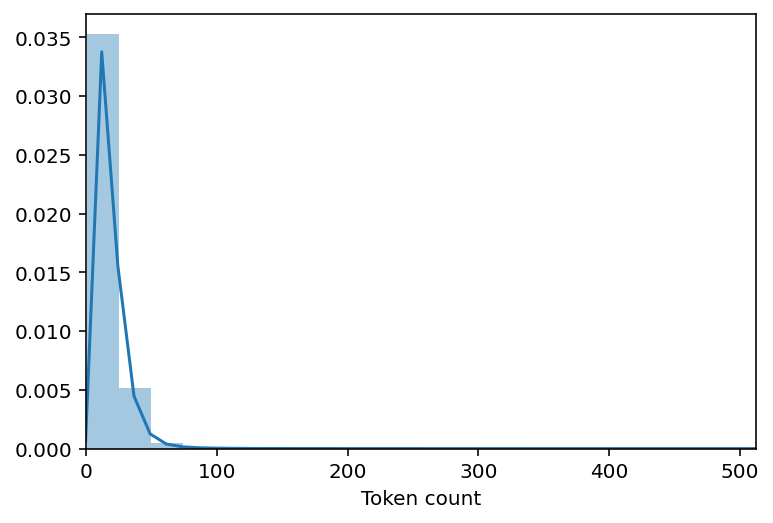

In [38]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(flat_list)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [40]:
dataset.save_to_disk(PATH_DATASET_DIR)

---